# Imports

## Libraries

In [1]:
#!pip install fasttext
#!pip install webvtt-py
#!pip install transformers
#!pip install deepmultilingualpunctuation
#!pip install pymatbridge
#!pip install langdetect
#!pip install py-readability-metrics
import pandas as pd
import warnings
import numpy as np
import numpy.linalg as la
import io
import sys
import itertools
import fasttext
import gensim
import gensim.corpora as corpora
import torch
import math
import nltk
import re
import webvtt
from statistics import mean
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from scipy.spatial import distance
from transformers import AutoTokenizer, T5ForConditionalGeneration, pipeline
from deepmultilingualpunctuation import PunctuationModel
from pymatbridge import Matlab
from bs4 import BeautifulSoup
from langdetect import detect
from readability import Readability
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from tqdm.notebook import tqdm
tqdm.pandas()
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

D:\anaconda3\envs\Bachelorthesis\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
D:\anaconda3\envs\Bachelorthesis\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
D:\anaconda3\envs\Bachelorthesis\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarni

GPU: NVIDIA GeForce GTX 980


## Data

In [ ]:
# For Google Colab
#from google.colab import drive
#drive.mount('/content/drive')
#df_kickstarter = pd.read_csv('./drive/MyDrive/Colab Notebooks/Thesis Data/kickstarter.csv')

In [2]:
df_kickstarter = pd.read_csv('kickstarter.csv')
df_indiegogo = pd.read_csv('indiegogo.csv')

# General Cleaning

## Kickstarter Dataset

In [5]:
# Filter rows based on column: 'project_country'
df_kickstarter = df_kickstarter[df_kickstarter['project_country'] == "US"]

In [6]:
# Filter rows based on column: 'project_currency'
df_kickstarter = df_kickstarter[df_kickstarter['project_currency'] == "USD"]

In [7]:
# Drop rows with missing data in column: 'project_title'
df_kickstarter = df_kickstarter.dropna(subset=['project_title'])

## Indiegogo Dataset

In [6]:
# Filter rows based on column: 'project_country'
df_indiegogo = df_indiegogo[df_indiegogo['project_country'] == "United States"]

In [7]:
# Drop rows with missing data in column: 'project_title'
df_indiegogo = df_indiegogo.dropna(subset=['project_title'])

# Readability Scores

## Functions

In [8]:
def preprocess_text(document: str, stemmer: nltk.stem.WordNetLemmatizer, en_stop: set) -> str:
    """Preprocesses a document to remove special characters/whitespace/etc

    Args:
        document (str): 
        stemmer (nltk.stem.WordNetLemmatizer): Stemmer from NLTK
        en_stop (set): Set of stop words, usually from NLTK

    Returns:
        str: preprocessed document
    """

    # Remove all the special characters
    document = re.sub(r'\W', ' ', document)

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)

    # Converting to Lowercase
    document = document.lower()

    # Lemmatization
    tokens = document.split()
    tokens = [stemmer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in en_stop]
    # Filtering short words
    tokens = [word for word in tokens if len(word) > 3]

    preprocessed_text = ' '.join(tokens)

    return tokens;
    #return preprocessed_text
    #return document

In [9]:
def preprocess_text_helper(t):
    stemmer = nltk.stem.WordNetLemmatizer()
    return preprocess_text(t, stemmer, stopwords.words('english'))

In [10]:
def tokenize_text(document: str) -> list:
    """Tokenizes a document into a list of words.

    Args:
        document (str): The text document to tokenize.

    Returns:
        list: A list of words.
    """
    # Tokenize the document into words
    tokens = nltk.word_tokenize(str(document))

    return tokens

In [11]:
def removeHTML(html_str):
    soup = BeautifulSoup(str(html_str), features="html.parser")
    return soup.get_text()

In [12]:
def detectLang(t):
    try:
        return detect(t)
    except:
        return None

In [ ]:
def flesch_kincaid(text):
    r = Readability(text)
    s = r.flesch_kincaid()
    return s.score

In [ ]:
def dale_chall(text):
    r = Readability(text)
    s = r.dale_chall()
    return s.score

In [ ]:
def ari(text):
    r = Readability(text)
    s = r.ari()
    return s.score

In [ ]:
def coleman_liau(text):
    r = Readability(text)
    s = r.coleman_liau()
    return s.score

In [ ]:
def gunning_fog(text):
    r = Readability(text)
    s = r.gunning_fog()
    return s.score

In [ ]:
def smog(text):
    r = Readability(text)
    s = r.smog()
    return s.score

In [ ]:
def spache(text):
    r = Readability(text)
    s = r.spache()
    return s.score

In [13]:
def numWords(text):
    r = Readability(text)
    try:
        t = r.statistics()
        return t['num_words']
    except:
        return None


## Specific Clean

In [ ]:
# Copy Dataframe
df_readability_kickstarter = df_kickstarter.copy()
df_readability_indiegogo = df_indiegogo.copy()

In [ ]:
df_readability_kickstarter_small = df_kickstarter.iloc[::100, :]
df_readability_indiegogo_small = df_indiegogo.iloc[::100, :]

In [ ]:
# Drop rows with missing data in column: 'project_description'
df_readability_kickstarter_small = df_readability_kickstarter_small.dropna(subset=['project_description'])
df_readability_indiegogo_small = df_readability_indiegogo_small.dropna(subset=['project_description'])
# Drop duplicate rows in column: 'project_description'
df_readability_kickstarter_small = df_readability_kickstarter_small.drop_duplicates(subset=['project_description'])
df_readability_indiegogo_small = df_readability_indiegogo_small.drop_duplicates(subset=['project_description'])

In [ ]:
df_readability_kickstarter_small['project_description'] = df_readability_kickstarter_small['project_description'].apply(removeHTML)
df_readability_indiegogo_small['project_description'] = df_readability_indiegogo_small['project_description'].apply(removeHTML)

In [ ]:
#df = df[df['project_description'].str.len() >= 100]

In [ ]:
#import nltk
#nltk.download('punkt')
df_readability_kickstarter_small['num_words'] = df_readability_kickstarter_small['project_description'].progress_apply(numWords)
df_readability_indiegogo_small['num_words'] = df_readability_indiegogo_small['project_description'].progress_apply(numWords)

In [ ]:
df_readability_kickstarter_small = df_readability_kickstarter_small[df_readability_kickstarter_small['num_words'] >= 100]
df_readability_indiegogo_small = df_readability_indiegogo_small[df_readability_indiegogo_small['num_words'] >= 100]

In [ ]:
#df['project_description'] = df['project_description'].apply(preprocess_text_helper)

In [ ]:
df_readability_kickstarter_small['project_lang'] = df_readability_kickstarter_small['project_description'].progress_apply(detectLang)
df_readability_indiegogo_small['project_lang'] = df_readability_indiegogo_small['project_description'].progress_apply(detectLang)

In [ ]:
df_readability_kickstarter_small = df_readability_kickstarter_small[df_readability_kickstarter_small['project_lang'] == 'en']
df_readability_indiegogo_small = df_readability_indiegogo_small[df_readability_indiegogo_small['project_lang'] == 'en']

## Calculate Scores

In [ ]:
df_readability_kickstarter_small['flesch_kincaid'] = df_readability_kickstarter_small['project_description'].progress_apply(flesch_kincaid)
df_readability_indiegogo_small['flesch_kincaid'] = df_readability_indiegogo_small['project_description'].progress_apply(flesch_kincaid)

In [ ]:
df_readability_kickstarter_small['dale_chall'] = df_readability_kickstarter_small['project_description'].progress_apply(dale_chall)
df_readability_indiegogo_small['dale_chall'] = df_readability_indiegogo_small['project_description'].progress_apply(dale_chall)

In [ ]:
df_readability_kickstarter_small['ari'] = df_readability_kickstarter_small['project_description'].progress_apply(ari)
df_readability_indiegogo_small['ari'] = df_readability_indiegogo_small['project_description'].progress_apply(ari)

In [ ]:
df_readability_kickstarter_small['coleman_liau'] = df_readability_kickstarter_small['project_description'].progress_apply(coleman_liau)
df_readability_indiegogo_small['coleman_liau'] = df_readability_indiegogo_small['project_description'].progress_apply(coleman_liau)

In [ ]:
df_readability_kickstarter_small['gunning_fog'] = df_readability_kickstarter_small['project_description'].progress_apply(gunning_fog)
df_readability_indiegogo_small['gunning_fog'] = df_readability_indiegogo_small['project_description'].progress_apply(gunning_fog)

In [ ]:
df_readability_kickstarter_small['spache'] = df_readability_kickstarter_small['project_description'].progress_apply(spache)
df_readability_indiegogo_small['spache'] = df_readability_indiegogo_small['project_description'].progress_apply(spache)

In [ ]:
#df = df.drop(columns=['project_description'])
#df.to_csv('ks_scores.csv')

In [ ]:
#df_temp = df.drop(columns=['transcript', 'transcript_chunks', 'transcript_chunk_emb'])
#df_temp.to_csv('ig_avg_sentence_length.csv')

# Sentiment Analysis (for experience - no promising results)

In [ ]:
nltk.download('vader_lexicon')

## Calculating Sentiment Scores

In [ ]:
df_sent = df_kickstarter.copy();
df_sent = df_sent.iloc[::1000, :]

# Load the pre-trained sentiment analysis model
sentiment_classifier_distilbert = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", max_length=512)
sentiment_classifier_bert = pipeline("sentiment-analysis", model="bert-base-uncased", max_length=512)
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()


# Compute the sentiment scores for each project description
sentiment_scores_distilbert = []
for description in tqdm(df_sent['project_description']):
    result = sentiment_classifier_distilbert(description)[0]
    sentiment_scores_distilbert.append(result['score'])

sentiment_scores_bert = []
for description in tqdm(df_sent['project_description']):
    result = sentiment_classifier_bert(description)[0]
    sentiment_scores_bert.append(result['score'])
sentiment_scores_Vader = []
for description in tqdm(df_sent['project_description']):
    result = sia.polarity_scores(description)[0]
    sentiment_scores_Vader.append(result['compound'])

# Add the sentiment scores as a new column to the dataframe
df_sent['sentiment_score_distilbert'] = sentiment_scores_distilbert
df_sent['sentiment_score_bert'] = sentiment_scores_bert
df_sent['sentiment_score_VADER'] = sentiment_scores_Vader

# Print the first 20 rows of the dataframe with the sentiment scores
print(df_sent.head(20))

## Scatterplot

In [ ]:
import matplotlib.pyplot as plt

# Calculate percentage funded for each project
df_sent['percentage_funded'] = df_sent['project_pledged'] / df_sent['project_goal']

# Extract the necessary columns from the dataframe
sentiment_distilbert = df_sent['sentiment_score_distilbert']
sentiment_bert = df_sent['sentiment_score_bert']
sentiment_vader = df_sent['sentiment_score_VADER']
percentage_funded = df_sent['percentage_funded']
pledged = df_sent['project_pledged']

# Plotting the data
plt.scatter(sentiment_distilbert, percentage_funded, c='red', label='DistilBERT')
plt.scatter(sentiment_bert, percentage_funded, c='blue', label='BERT')
plt.scatter(sentiment_vader, percentage_funded, c='green', label='VADER')

# Set the labels and title
plt.xlabel('Sentiment Score')
plt.ylabel('Percentage of Money Funded')
plt.title('Sentiment vs. Percentage of Money Funded')

# Add a legend
plt.legend()

# Show the plot
plt.show()

## Gaussian Process Regression

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

# Define the kernel for the Gaussian process
kernel = ConstantKernel() * RBF() + WhiteKernel()

# Define the function to fit with the Gaussian process
def func(x, a, b):
    return a * x + b

# Fit the Gaussian process to the sentiment and percentage funded data points
x = np.array(sentiment_distilbert)
y = np.array(percentage_funded)
popt, pcov = curve_fit(func, x, y)
gp = GaussianProcessRegressor(kernel=kernel).fit(x.reshape(-1, 1), y)

# Plot the scatter plot and the fitted Gaussian process
plt.scatter(x, y, c='red', label='Data')
x_pred = np.linspace(min(x), max(x), 100)
y_pred, y_std = gp.predict(x_pred.reshape(-1, 1), return_std=True)
plt.plot(x_pred, y_pred, 'k-', label='Gaussian Process')
plt.fill_between(x_pred, y_pred - y_std, y_pred + y_std,
                 alpha=0.2, color='gray', label='95% confidence interval')
plt.xlabel('Sentiment Score')
plt.ylabel('Percentage of Money Funded')
plt.title('Sentiment vs. Percentage of Money Funded')
plt.legend(loc='lower right')

# Show the plot
plt.show()

## Polynomial Regression

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate percentage funded for each project
df_sent['percentage_funded'] = df_sent['project_pledged'] / df_sent['project_goal'] * 100

# Extract the necessary columns from the dataframe
sentiment_distilbert = df_sent['sentiment_score_distilbert']
sentiment_bert = df_sent['sentiment_score_bert']
sentiment_vader = df_sent['sentiment_score_VADER']
percentage_funded = df_sent['percentage_funded']
pledged = df_sent['project_pledged']

# Plotting the data
#plt.scatter(sentiment_distilbert, percentage_funded, c='red', label='DistilBERT')
#plt.scatter(sentiment_bert, percentage_funded, c='blue', label='BERT')
#plt.scatter(sentiment_vader, percentage_funded, c='green', label='VADER')

# Fit a polynomial curve to the data
degree = 100  # Adjust the degree of the polynomial curve
p_distilbert = np.polyfit(sentiment_distilbert, percentage_funded, deg=degree)
p_bert = np.polyfit(sentiment_bert, percentage_funded, deg=degree)
p_vader = np.polyfit(sentiment_vader, percentage_funded, deg=degree)

# Create functions to evaluate the polynomial curves
curve_distilbert = np.poly1d(p_distilbert)
curve_bert = np.poly1d(p_bert)
curve_vader = np.poly1d(p_vader)

# Generate points along the x-axis for plotting the curves
x = np.linspace(0, 1, 100)

# Plot the polynomial curves
plt.plot(x, curve_distilbert(x), c='red', label='DistilBERT Curve')
plt.plot(x, curve_bert(x), c='blue', label='BERT Curve')
plt.plot(x, curve_vader(x), c='green', label='VADER Curve')

# Set the limits of the x-axis
plt.xlim(0.5, 1)

# Set the labels and title
plt.xlabel('Sentiment Score')
plt.ylabel('Percentage of Money Funded')
plt.title('Sentiment vs. Percentage of Money Funded')

#Limit plot
ax = plt.gca()
ax.set_ylim([0, 1000])

# Add a legend
plt.legend()

# Show the plot
plt.show()

# General Analysis

## Successful Projects over the Years

In [12]:
df_indiegogo.head(5)

,project_id,project_slug,project_title,project_owner,project_category_id,project_launched_at,project_funding_ends_at,project_goal,project_funding_days,project_currency_iso_num,project_collected_funds,project_funding_type,project_contributions_count,project_rewards,project_country,project_status,project_main_video_url,project_description
0,1855,1--11,1,Bradford Thomason,56.0,2009-07-01 12:52:17,2010-06-30 23:59:00,10000,364.0,840,0.0,flexible,0,3,United States,ended,NaN,1
1,2124,3,3,Brandon Christian,60.0,2009-08-29 22:11:24,2010-06-30 23:59:00,1500,305.0,840,0.0,flexible,0,2,Russian Federation,ended,https://www.youtube.com/watch?v=BjlK0oIryKk,"Logline:\n\nHe’s here again, the son of God. H..."
2,2219567,5,5,chocolate cake,60.0,2018-01-01 01:11:04,2018-01-31 23:59:59,500,30.0,840,561.0,fixed,11,1,South Africa,ended,NaN,<div>\nA quick update (02-25-2018) for the pur...
3,882868,6,6,Jatin Goyal,NaN,2021-08-03 02:11:21,NaN,500,NaN,840,0.0,flexible,0,0,NaN,frozen,NaN,<div> <h3>Short Summary</h3> Contributors fund...
4,2346799,7,Аудиокнига Темная Башня 7,Roman Volkov,73.0,2018-03-03 02:59:49,2018-05-02 23:59:59,3000,60.0,840,0.0,flexible,0,0,Russian Federation,ended,https://www.youtube.com/watch?v=U6M-sf3awj8,<div>\n<h3>Я - создатель цикла аудиокниг ТЕМНА...


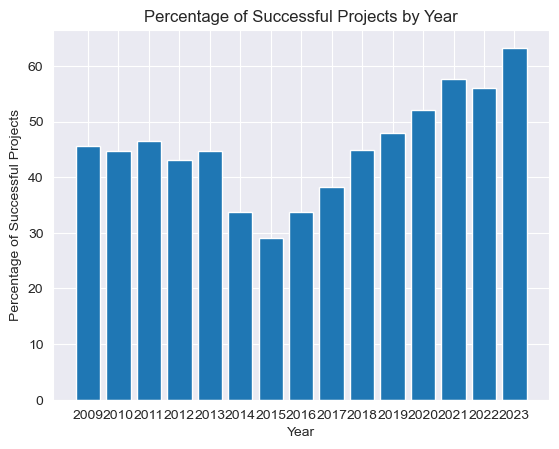

In [13]:
df_kickstarter['date'] = pd.to_datetime(df_kickstarter['project_launched_at']).dt.to_period('Y')  # create a new column with the year

# group the data by year and project state, and calculate the percentage of successful projects for each year
grouped = df_kickstarter.groupby(['date', 'project_state'])['project_state'].count().unstack()
grouped['success_percent'] = grouped['successful'] / grouped.sum(axis=1) * 100

# create a bar chart with the percentage of successful projects for each year
plt.bar(grouped.index.astype(str), grouped['success_percent'])
plt.xlabel('Year')
plt.ylabel('Percentage of Successful Projects')
plt.title('Percentage of Successful Projects by Year')
plt.show()


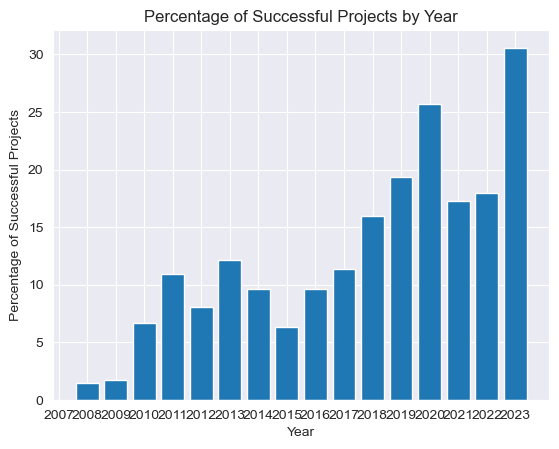

In [21]:
df_indiegogo['date'] = pd.to_datetime(df_indiegogo['project_launched_at']).dt.to_period('Y')  # create a new column with the year

# calculate project success based on project_goal and project_collected_funds
df_indiegogo['success'] = np.where(df_indiegogo['project_collected_funds'] >= df_indiegogo['project_goal'], 1, 0)

# group the data by year and project success, and calculate the percentage of successful projects for each year
grouped = df_indiegogo.groupby(['date', 'success'])['success'].count().unstack()
grouped['success_percent'] = grouped[1] / grouped.sum(axis=1) * 100

# create a bar chart with the percentage of successful projects for each year
plt.bar(grouped.index.astype(str), grouped['success_percent'])
plt.xlabel('Year')
plt.ylabel('Percentage of Successful Projects')
plt.title('Percentage of Successful Projects by Year')
plt.show()

## Violin Plot

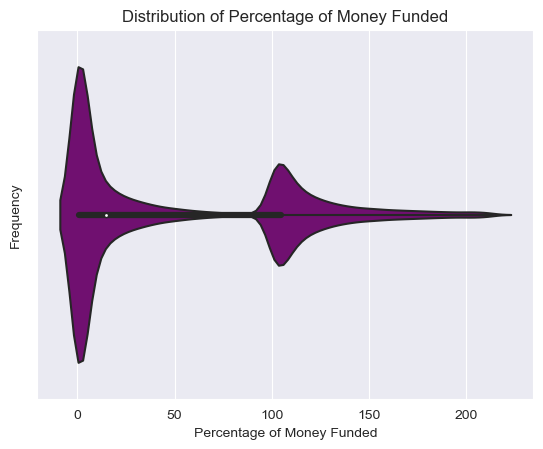

In [17]:
df_violin_kickstarter = df_kickstarter.copy()
# Calculate percentage funded for each project
df_violin_kickstarter = df_violin_kickstarter[df_violin_kickstarter['project_goal'] >= 0]
df_violin_kickstarter = df_violin_kickstarter[df_violin_kickstarter['project_pledged'] >= 0]
df_violin_kickstarter['percentage_funded'] = df_violin_kickstarter['project_pledged'] / df_violin_kickstarter['project_goal'] * 100

#Remove top 10% of outliers
q = df_violin_kickstarter['percentage_funded'].quantile(0.9)
df_violin_kickstarter = df_violin_kickstarter[df_violin_kickstarter['percentage_funded'] < q]

# Create a violin plot of percentage funded
sns.violinplot(x=df_violin_kickstarter['percentage_funded'], color='purple')

# Set the labels and title
plt.xlabel('Percentage of Money Funded')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage of Money Funded')

# Show the plot
plt.show()

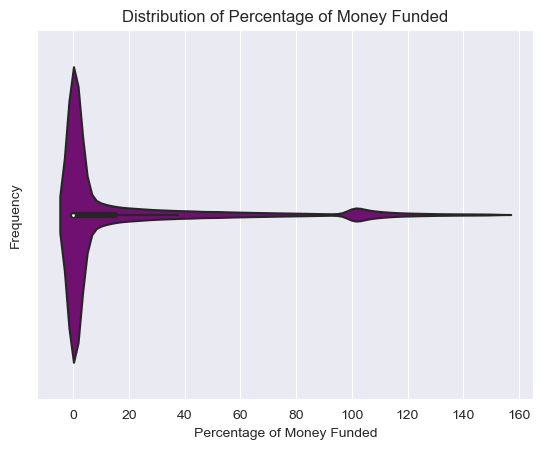

In [18]:
df_violin_indiegogo = df_indiegogo.copy()

# Calculate percentage funded for each project
df_violin_indiegogo = df_violin_indiegogo[df_violin_indiegogo['project_goal'] >= 0]
df_violin_indiegogo = df_violin_indiegogo[df_violin_indiegogo['project_collected_funds'] >= 0]
df_violin_indiegogo['percentage_funded'] = df_violin_indiegogo['project_collected_funds'] / df_violin_indiegogo['project_goal'] * 100

#Remove top 3% of outliers
q = df_violin_indiegogo['percentage_funded'].quantile(0.97)
df_violin_indiegogo = df_violin_indiegogo[df_violin_indiegogo['percentage_funded'] < q]

# Create a violin plot of percentage funded
sns.violinplot(x=df_violin_indiegogo['percentage_funded'], color='purple')

# Set the labels and title
plt.xlabel('Percentage of Money Funded')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage of Money Funded')

# Show the plot
plt.show()

## Most succesful Categories

# Topic Modelling

## LDA Topic Modelling

In [27]:
# Copy Dataframe
df_lda_kickstarter = df_kickstarter.copy()
df_lda_kickstarter = df_lda_kickstarter.iloc[::200, :]
df_lda_kickstarter.head(10)

,project_id,project_url,project_video_url,project_title,project_blurb,project_creator_id,project_location,project_country,project_category_id,project_parent_category_id,...,project_state,updates_until_deadline,project_rewards,project_launched_at,project_successful_at,project_deadline,project_staff_pick,project_creator_project_number,project_description,date
0,1860890148,https://www.kickstarter.com/projects/perry/gra...,https://ksr-video.imgix.net/projects/3/video-1...,Grace Jones Does Not Give A F$#% T-Shirt (limi...,About two years ago I realized a profound trut...,4,Brooklyn,US,9,NaN,...,failed,2,1,2009-04-21 21:02:48,NaN,2009-05-31 08:59:59,0,1.0,About two years ago I realized a profound trut...,2009
284,691072555,https://www.kickstarter.com/projects/132377952...,https://ksr-video.imgix.net/projects/618/video...,"Redmoon Theater, meet Xenia.",Our 9 year old daughter wants to attend the fi...,132377952,Chicago,US,17,NaN,...,successful,0,4,2010-06-08 18:47:08,2010-07-08 17:45:09,2010-07-08 17:44:00,0,1.0,"This summer, the spectacular and astonishing R...",2010
588,1713155086,https://www.kickstarter.com/projects/132654706...,NaN,ABCyz New York (Canceled),ABCyz is a collaboratively curated show of art...,1326547064,New York,US,1,NaN,...,canceled,1,6,2009-09-22 21:01:53,NaN,2009-10-10 11:59:00,0,1.0,"Launching on October 2, 2009, ABCyz brings tog...",2009
897,1061427416,https://www.kickstarter.com/projects/130971057...,https://ksr-video.imgix.net/projects/1780/vide...,"""Dancing With the Spirits"" - Documentary Film",Risking everything to answer the call of Spiri...,1309710577,New York,US,30,11.0,...,failed,6,6,2010-05-05 01:55:18,NaN,2010-08-01 09:00:00,0,1.0,"A highly personal film, set against the backdr...",2010
1187,562858107,https://www.kickstarter.com/projects/acidjazzp...,NaN,Let&#39;s take back the music industry!,It&#39;s time to take the music industry back ...,854132408,Harlem,US,41,14.0,...,failed,0,5,2010-01-05 22:53:18,NaN,2010-03-05 22:18:00,0,1.0,I am an independent recording artist. An indep...,2010
1468,569464549,https://www.kickstarter.com/projects/textfyre/...,NaN,Kickstart Textfyre!!! (Canceled),This project is intended to raise cash to prom...,1028111154,Chicago,US,47,18.0,...,canceled,4,4,2010-02-23 17:44:37,NaN,2010-03-31 07:00:00,0,1.0,"My name is David Cornelson, a passionate Inter...",2010
1753,158696938,https://www.kickstarter.com/projects/complicat...,https://ksr-video.imgix.net/projects/3466/vide...,Self Help,Help us get to our goal of $5000 to shoot SELF...,1287875511,Denmark,US,30,11.0,...,successful,4,5,2010-06-01 21:47:21,2010-07-31 06:00:07,2010-07-31 06:00:00,0,2.0,WON'T YOU HELP US MAKE A FILM THIS SUMMER? Thi...,2010
2031,526641071,https://www.kickstarter.com/projects/marahstra...,NaN,Help us transfer Carl Boenish&#39;s archive an...,"We are seeking funds to transfer over 90,000 f...",1864895996,Hawthorne,US,30,11.0,...,successful,18,31,2010-04-29 20:38:37,2010-06-14 05:30:08,2010-06-14 05:16:00,1,1.0,"""Happy are those who dream dreams, and are wil...",2010
2289,242696087,https://www.kickstarter.com/projects/modernevi...,NaN,"Time, emiT, and Time Again",TIME + LOVE = ? In my new collection of short ...,1317141860,Phoenix,US,47,18.0,...,successful,3,7,2010-04-02 08:32:47,2010-05-16 09:00:12,2010-05-16 08:59:00,0,1.0,TIME + LOVE = ?? I am working on a new collect...,2010
2550,712033017,https://www.kickstarter.com/projects/wootom/we...,https://ksr-video.imgix.net/projects/4874/vide...,West of Dead -- Trailer,Receive instant immunity by supporting indy fi...,9160721,Salt Lake City,US,32,11.0,...,successful,3,5,2010-04-28 23:26:40,2010-05-17 08:00:08,2010-05-17 07:59:00,1,2.0,Howdy Kickstarters! We're guessing you just fi...,2010


### Specific Clean

In [28]:
# Remove the columns
df_lda_kickstarter.drop(df_lda_kickstarter.columns.difference(['project_description', 'project_state']), axis=1, inplace=True)
# Print out the first rows of papers
df_lda_kickstarter.head()

,project_state,project_description
0,failed,About two years ago I realized a profound trut...
284,successful,"This summer, the spectacular and astonishing R..."
588,canceled,"Launching on October 2, 2009, ABCyz brings tog..."
897,failed,"A highly personal film, set against the backdr..."
1187,failed,I am an independent recording artist. An indep...


In [29]:
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

In [30]:
df_lda_kickstarter['project_description'] = df_lda_kickstarter['project_description'].progress_apply(removeHTML)

  0%|          | 0/1953 [00:00<?, ?it/s]

In [31]:
df_lda_kickstarter['project_lang'] = df_lda_kickstarter['project_description'].progress_apply(detectLang)

  0%|          | 0/1953 [00:00<?, ?it/s]

In [32]:
df_lda_kickstarter = df_lda_kickstarter[df_lda_kickstarter['project_lang'] == 'en']

In [33]:
df_lda_kickstarter['project_description'] = df_lda_kickstarter['project_description'].progress_apply(preprocess_text_helper)

  0%|          | 0/1932 [00:00<?, ?it/s]

In [34]:
df_lda_kickstarter.head(20)

,project_state,project_description,project_lang
0,failed,"[year, realized, profound, truth, grace, jones...",en
284,successful,"[summer, spectacular, astonishing, redmoon, th...",en
588,canceled,"[launching, october, 2009, abcyz, brings, toge...",en
897,failed,"[highly, personal, film, backdrop, richly, tex...",en
1187,failed,"[independent, recording, artist, independent, ...",en
1468,canceled,"[name, david, cornelson, passionate, interacti...",en
1753,successful,"[help, make, film, summer, august, host, cast,...",en
2031,successful,"[happy, dream, dream, willing, price, dream, c...",en
2289,successful,"[time, love, working, collection, short, story...",en
2550,successful,"[howdy, kickstarters, guessing, finished, watc...",en


In [35]:
data = df_lda_kickstarter['project_description'].tolist()
#data_words = tokenize_text(data)
print(data[0][1])

realized


In [36]:
# create dictionary and corpus
dictionary = corpora.Dictionary(data)
corpus = [dictionary.doc2bow(tokens) for tokens in data]

In [42]:
optimal_num_topics = 19

### Applying LDA algorithm

In [ ]:
# calculate optimal number of topics
#start = 2
#limit = 100
#step = 1
#coherence_scores = []
#for num_topics in range(start, limit, step):
#    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, workers=8)
#    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=data, dictionary=dictionary, coherence='c_v')
#    coherence_lda = coherence_model_lda.get_coherence()
#    coherence_scores.append(coherence_lda)
#    print("Number of Topics: ", num_topics, "    Coherence Score: ", coherence_lda)

# plot coherence scores to visualize optimal number of topics
#x = range(start, limit, step)
#plt.plot(x, coherence_scores)
#plt.xlabel("Number of Topics")
#plt.ylabel("Coherence Score")
#plt.show()

# train LDA model with optimal number of topics
#optimal_num_topics = coherence_scores.index(max(coherence_scores)) + start
optimal_num_topics = 19
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics, passes=20, workers=8,  per_word_topics=True, chunksize=100, iterations=100,  eval_every=None, gamma_threshold=0.001)

# print topics and associated words
for idx, topic in lda_model.print_topics(num_topics=optimal_num_topics, num_words=10):
    print('Topic: {} \nWords: {}'.format(idx, topic))

In [ ]:
from collections import Counter

# Count word occurrences
word_counts = Counter()
for doc in corpus:
    for word_id, count in doc:
        word = dictionary[word_id]
        word_counts[word] += count

# Get most frequent words
most_common = word_counts.most_common(100)
print(most_common)

### Load Model

In [22]:
lda_model = gensim.models.LdaModel.load('./lda_model')

### Visualization of Topics

In [37]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Create the visualization
vis = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization in Jupyter notebook
pyLDAvis.display(vis)

### Calculating probabilities that a successful project belongs to a topic t = P(project belongs to topic t | project is successful)

In [38]:
# Create function to calculate topic distribution
def get_topic_distribution(text):
    bow = dictionary.doc2bow(text)
    topic_probs = lda_model.get_document_topics(bow, per_word_topics=False)
    return topic_probs

In [39]:
# Filter successful projects
success_projects = df_lda_kickstarter[df_lda_kickstarter['project_state'] == 'successful']

In [40]:
# Calculate topic distribution for successful projects
success_projects['topic_distribution'] = success_projects['project_description'].apply(get_topic_distribution)

In [43]:
# Sum up topic probabilities and calculate mean for each topic
topic_prob_sums = {i: 0 for i in range(optimal_num_topics)}
topic_counts = {i: 0 for i in range(optimal_num_topics)}
max_topic_counts = {i: 0 for i in range(optimal_num_topics)}

for dist in success_projects['topic_distribution']:
    try:
        max_prob = 0
        max_topic = 0
        for topic, prob in dist:
            topic_prob_sums[topic] += prob
            topic_counts[topic] += 1
            if prob > max_prob:
                max_prob = prob
                max_topic = topic
        max_topic_counts[max_topic] += 1
    except ValueError:
        print(dist)

# stores the mean probability of each topic across all documents, weighted by the probability of that topic in each document
topic_means_weighted = {topic: topic_prob_sums[topic] / len(success_projects) for topic in topic_prob_sums}
# stores the proportion of documents where each topic has the highest probability
topic_means_maxprob = {topic: max_topic_counts[topic] / len(success_projects) for topic in topic_prob_sums}

In [44]:
# Sort topics by success rate
sorted_topics = sorted(topic_means_weighted.items(), key=lambda x: x[1], reverse=True)

# Print topics and associated success rates
for topic, success_rate in sorted_topics:
    print(f"Topic {topic}: Mean Weighted Probability = {round(success_rate, 3)} | Relative max Probability = {round(topic_means_maxprob[topic], 3)} | Relative occurrence = {round(topic_counts[topic]/ len(success_projects), 3)}")

Topic 14: Mean Weighted Probability = 0.26 | Relative max Probability = 0.311 | Relative occurrence = 0.648
Topic 13: Mean Weighted Probability = 0.139 | Relative max Probability = 0.133 | Relative occurrence = 0.535
Topic 6: Mean Weighted Probability = 0.128 | Relative max Probability = 0.131 | Relative occurrence = 0.49
Topic 18: Mean Weighted Probability = 0.095 | Relative max Probability = 0.084 | Relative occurrence = 0.422
Topic 9: Mean Weighted Probability = 0.072 | Relative max Probability = 0.072 | Relative occurrence = 0.322
Topic 8: Mean Weighted Probability = 0.063 | Relative max Probability = 0.07 | Relative occurrence = 0.279
Topic 17: Mean Weighted Probability = 0.058 | Relative max Probability = 0.054 | Relative occurrence = 0.285
Topic 7: Mean Weighted Probability = 0.034 | Relative max Probability = 0.027 | Relative occurrence = 0.21
Topic 3: Mean Weighted Probability = 0.032 | Relative max Probability = 0.03 | Relative occurrence = 0.175
Topic 4: Mean Weighted Probab

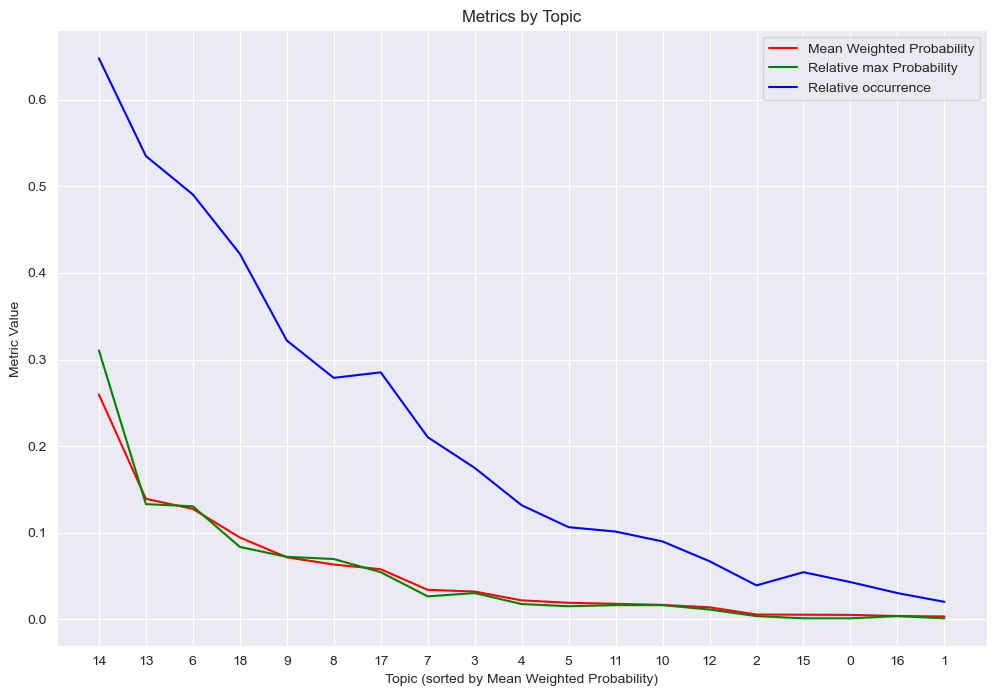

In [45]:
# Extract the metrics to be plotted
mean_weighted_probs = [success_rate for _, success_rate in sorted_topics]
max_probs = [topic_means_maxprob[topic] for topic, _ in sorted_topics]
relative_occurrences = [topic_counts[topic]/ len(success_projects) for topic, _ in sorted_topics]

# Set up plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the metrics
ax.plot(mean_weighted_probs, color='red', label='Mean Weighted Probability')
ax.plot(max_probs, color='green', label='Relative max Probability')
ax.plot(relative_occurrences, color='blue', label='Relative occurrence')

# Set the x-axis tick labels to be the topic numbers
ax.set_xticks(range(len(sorted_topics)))
ax.set_xticklabels([f"{topic}" for topic, _ in sorted_topics])

# Set plot title and labels
ax.set_title('Metrics by Topic')
ax.set_xlabel('Topic (sorted by Mean Weighted Probability)')
ax.set_ylabel('Metric Value')
ax.legend()

# Display plot
plt.show()

### Calculating probability of success if project belongs to certain topic t = P(project is successful | project belongs to topic t)

In [46]:
# Calculate topic distribution for all projects
df_lda_kickstarter['topic_distribution'] = df_lda_kickstarter['project_description'].apply(get_topic_distribution)

In [47]:
# Sum up topic probabilities and calculate mean for each topic
topic_prob_sums_total = {i: 0 for i in range(optimal_num_topics)}
topic_counts_total = {i: 0 for i in range(optimal_num_topics)}
max_topic_counts_total = {i: 0 for i in range(optimal_num_topics)}

for dist in df_lda_kickstarter['topic_distribution']:
    try:
        max_prob = 0
        max_topic = 0
        for topic, prob in dist:
            topic_prob_sums_total[topic] += prob
            topic_counts_total[topic] += 1
            if prob > max_prob:
                max_prob = prob
                max_topic = topic
        max_topic_counts_total[max_topic] += 1
    except ValueError:
        print(dist)

In [48]:
# the ratio of the sum of topic probabilities for successful projects to the sum of topic probabilities for all projects for each topic
success_rate_weighted_prob = [topic_prob_sums[i]/topic_prob_sums_total[i] for i in range(optimal_num_topics)]
# the ratio of the count of successful projects with highest probability in each topic to the count of all projects with highest probability in that topic
success_rate_max_prob = [max_topic_counts[i]/max_topic_counts_total[i] for i in range(optimal_num_topics)]
# the ratio of the count of successful projects with any probability >0 for each topic to the count of all projects for that topic
successful_occurrences = [topic_counts[i]/topic_counts_total[i] for i in range(optimal_num_topics)]

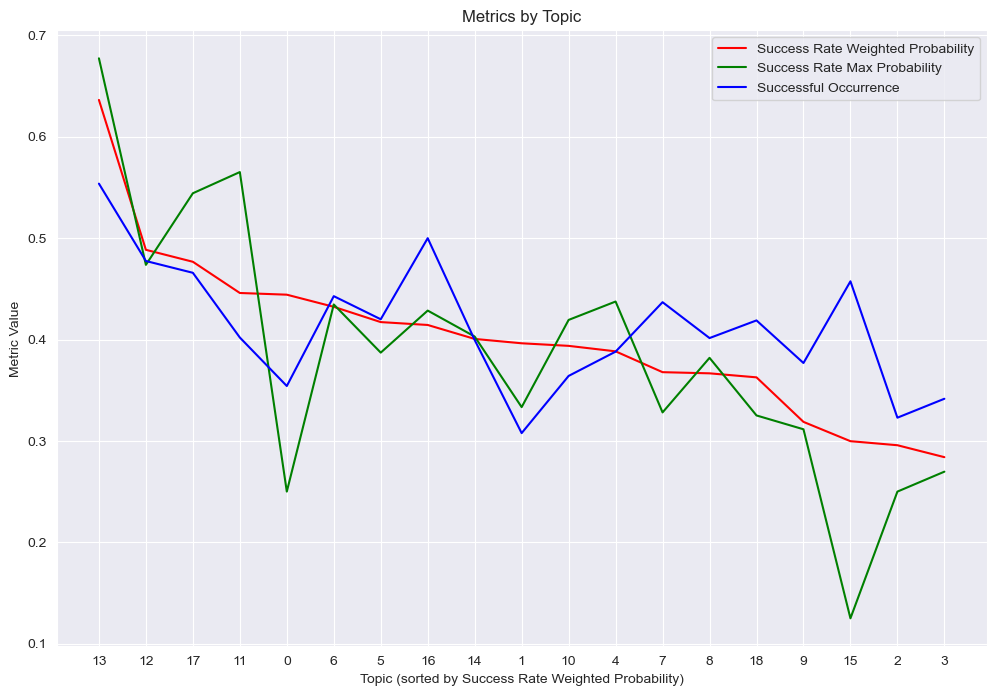

In [50]:
# Combine the metrics with their corresponding topic numbers and sort by success_rate_weighted_prob
sorted_topics = sorted(enumerate(success_rate_weighted_prob), key=lambda x: x[1], reverse=True)

# Extract the metrics to be plotted, sorted by success_rate_weighted_prob
mean_weighted_probs = [success_rate_weighted_prob[i] for i, _ in sorted_topics]
max_probs = [success_rate_max_prob[i] for i, _ in sorted_topics]
relative_occurrences = [successful_occurrences[i] for i, _ in sorted_topics]

# Set up plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the metrics
ax.plot(mean_weighted_probs, color='red', label='Success Rate Weighted Probability')
ax.plot(max_probs, color='green', label='Success Rate Max Probability')
ax.plot(relative_occurrences, color='blue', label='Successful Occurrence')

# Set the x-axis tick labels to be the sorted topic numbers
ax.set_xticks(range(len(sorted_topics)))
ax.set_xticklabels([f"{topic}" for topic, _ in sorted_topics])

# Set plot title and labels
ax.set_title('Metrics by Topic')
ax.set_xlabel('Topic (sorted by Success Rate Weighted Probability)')
ax.set_ylabel('Metric Value')
ax.legend()

# Display plot
plt.show()

## BERTopic

In [51]:
# Copy Dataframe
df_bertopic_kickstarter = df_kickstarter.copy()
df_bertopic_kickstarter = df_bertopic_kickstarter.iloc[::20, :]

### Specific Clean

In [52]:
# Remove the columns
df_bertopic_kickstarter.drop(df_bertopic_kickstarter.columns.difference(['project_description']), axis=1, inplace=True)

In [53]:
df_bertopic_kickstarter['project_description'] = df_bertopic_kickstarter['project_description'].progress_apply(removeHTML)

  0%|          | 0/19529 [00:00<?, ?it/s]

In [ ]:
df_bertopic_kickstarter['project_lang'] = df_bertopic_kickstarter['project_description'].progress_apply(detectLang)

  0%|          | 0/19529 [00:00<?, ?it/s]

In [ ]:
df_bertopic_kickstarter = df_bertopic_kickstarter[df_bertopic_kickstarter['project_lang'] == 'en']

### Create BERTopic model

In [ ]:
from bertopic import BERTopic

vectorizer_model = CountVectorizer(stop_words="english")
topic_model = BERTopic(vectorizer_model=vectorizer_model, language="english", calculate_probabilities=True, verbose=True, n_gram_range=(1,2))
topics, probs = topic_model.fit_transform(df_bertopic_kickstarter['project_description'].tolist())

### Load Model

In [ ]:
topic_model = BERTopic.load('/path/to/bertopic_model')

### Visualization of Topics

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [ ]:
topic_model.visualize_barchart(top_n_topics=100)

In [ ]:
topic_model.get_document_info(df_bertopic_kickstarter['project_description'].tolist())

In [ ]:
freq = topic_model.get_topic_info(); freq.head(100)

# Similarity of Texts over Time

## Cosine similarity (Semantic)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [15]:
# Copy Dataframe
df_cosinesim_kickstarter = df_kickstarter.copy()

In [16]:
# Group project descriptions by year
grouped_descriptions = df_cosinesim_kickstarter.groupby('date')['project_description'].apply(list)

In [18]:
# Compute TF-IDF vectors for the project descriptions
vectorizer = TfidfVectorizer(stop_words='english')

In [21]:
mean_similarities = []
years = []

# Iterate over each year and calculate mean cosine similarity
for year, descriptions in grouped_descriptions.items():
    # Convert the list of descriptions into a single string
    descriptions = [str(desc) for desc in descriptions]  # Convert elements to strings
    corpus = ' '.join(descriptions)

    # Compute the TF-IDF vectors
    tfidf_vectors = vectorizer.fit_transform([corpus])

    # Calculate cosine similarity matrix
    cosine_matrix = cosine_similarity(tfidf_vectors[0:1], tfidf_vectors)

    # Get the cosine similarity scores
    similarity_scores = cosine_matrix[0][1:]

    # Check if the similarity scores list is empty
    if len(similarity_scores) == 0:
        mean_similarity = np.nan
    else:
        # Calculate mean similarity across document pairs
        mean_similarity = np.mean(similarity_scores)

    # Append the mean similarity and year to the respective lists
    mean_similarities.append(mean_similarity)
    years.append(year)

In [23]:
# Create a DataFrame with years and mean cosine similarity scores
similarity_df = pd.DataFrame({'Year': years, 'Mean Similarity': mean_similarities})

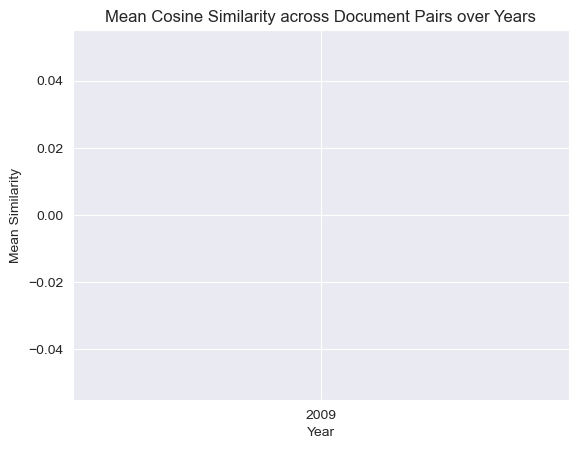

In [29]:
# Plot the timeline of mean cosine similarity over years
plt.plot(similarity_df['Year'].astype(str), similarity_df['Mean Similarity'])
plt.xlabel('Year')
plt.ylabel('Mean Similarity')
plt.title('Mean Cosine Similarity across Document Pairs over Years')
plt.show()

# Save Session